In [30]:
import os
import sys
import numpy as np


import umap.umap_ as umap

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


#ALLDIR='/mnt/d/DATA/XFMDATA/2023/Nicholls_Loren/mounts_ansto_230418/230420_qz200um_cut/tiff'
BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
output_directory = os.path.join(image_directory, "outputs")

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
#image_directory = ALLDIR

In [31]:
%load_ext autoreload
%autoreload 2

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=False
FORCE_CLUST=False
OVERWRITE=True

elements, data, dims, sd_data, sd_dims = processops.compile(image_directory)

data, dims = processops.data_crop(data, dims, 100, 500, 150, 350)

#data, elements, dims, sd_data, sd_dims = processops.compile(image_directory)

data = np.sqrt(data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo
-----
Map files found: 20
Elements identified: ['Al', 'As', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mn', 'Mo', 'MoL', 'Ni', 'P', 'S', 'Si', 'Ti', 'V', 'Zn', 'sum']
-----------------
READING MAP DATA
Initial shape: (393, 700, 20)
Revised shape: (392, 700, 20)
-----
-----------------
READING VARIANCE DATA
Initial shape: (197, 350, 20)
-----
Al -- data: 0.054427698254585266, var: 1.4911073446273804, ratio: 54.79222500472953
As -- data: 0.0013860455946996808, var: 0.011784680187702179, ratio: 17.00475111752093
Ca -- data: 0.0773456022143364, var: 0.055722881108522415, ratio: 1.4408803994855677
Cl -- data: 0.003481516381725669, var: 0.12431034445762634, ratio: 71.41160967107669
Compton -- data: 5.356117216415157e-10, var: 1.7024261111941996e-08, ratio: 63.56941203514703
Cr -- data

(80000, 20)
ELEMENT MAP: S
S, max: 1.04, 98: 0.95, avg: 0.63


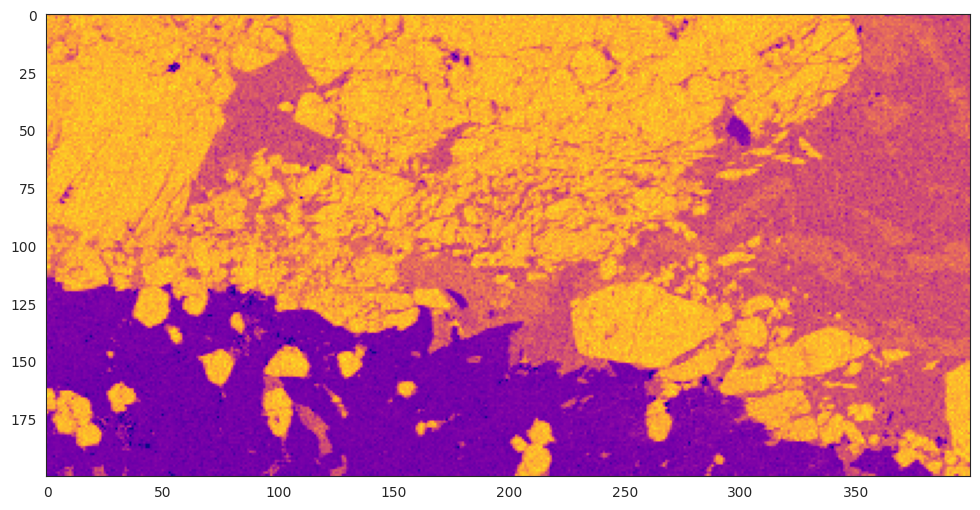

(68950, 20)
ELEMENT MAP: S
S, max: 3.84, 98: 2.74, avg: 1.91


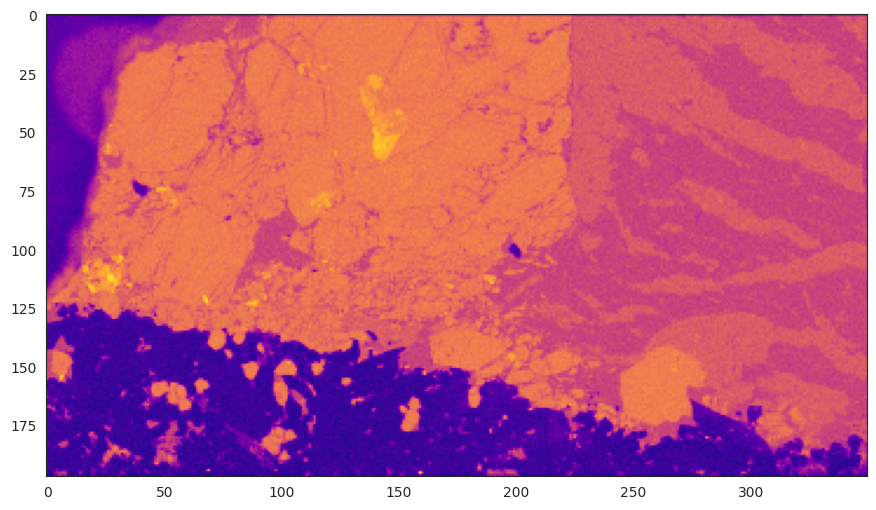

In [32]:
ELEMENT = "S"

vis.show_map(data, dims, elements, ELEMENT)

vis.show_map(sd_data, sd_dims, elements, ELEMENT)

LOADING EMBED
LOADING CATS
13
(80000,)
-1
0


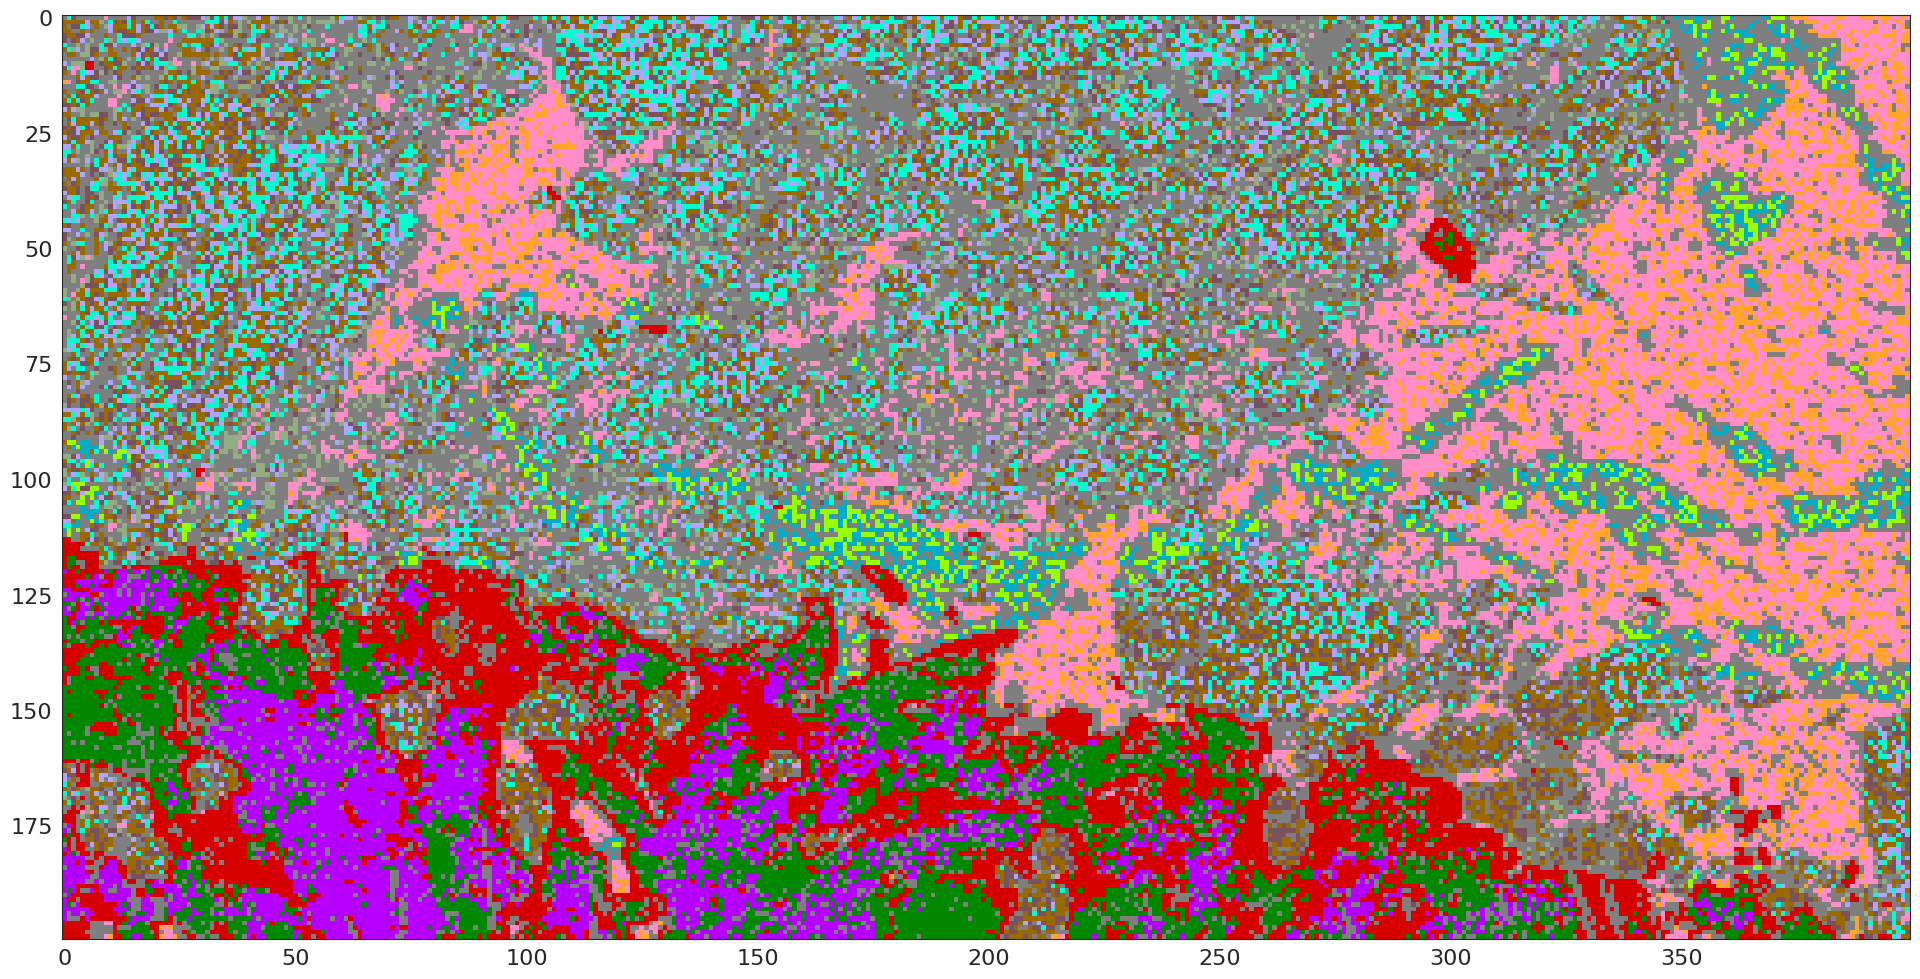

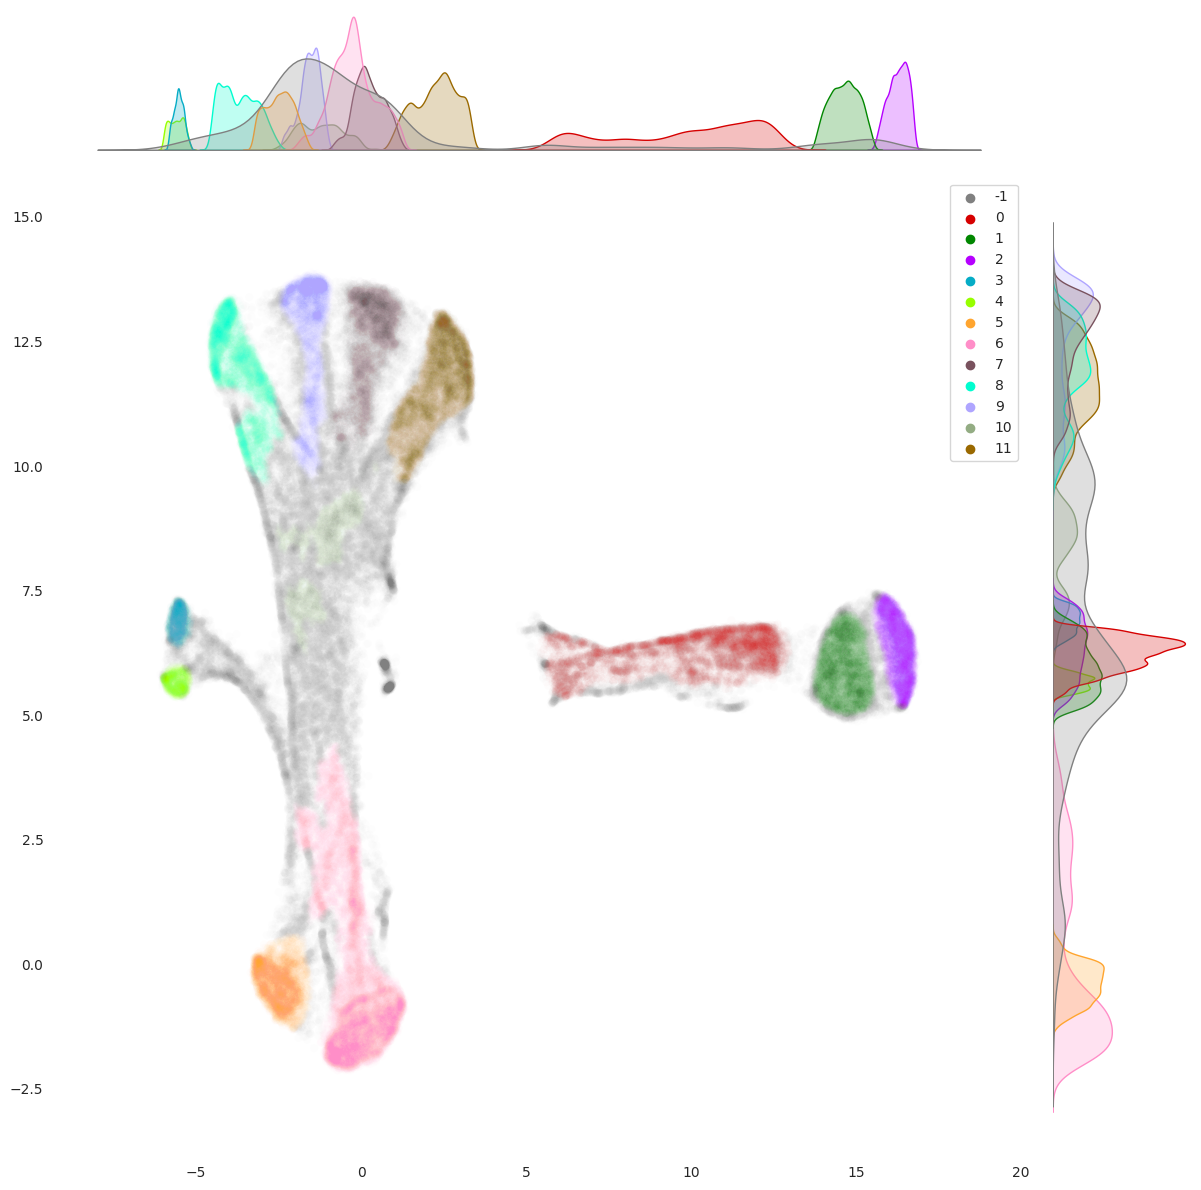

Al, max: 0.27, 98: 0.08, avg: 0.02
As, max: 0.03, 98: 0.02, avg: 0.00
Ca, max: 1.60, 98: 0.51, avg: 0.09
Cl, max: 0.03, 98: 0.02, avg: 0.00
Compton, max: 0.93, 98: 0.26, avg: 0.05
Cr, max: 0.05, 98: 0.03, avg: 0.01
Cu, max: 1.02, 98: 0.99, avg: 0.30
Fe, max: 1.83, 98: 1.77, avg: 1.28
K, max: 0.13, 98: 0.02, avg: 0.00
Mn, max: 0.51, 98: 0.14, avg: 0.06
Mo, max: 0.47, 98: 0.35, avg: 0.17
MoL, max: 0.16, 98: 0.06, avg: 0.01
Ni, max: 0.02, 98: 0.02, avg: 0.00
P, max: 0.05, 98: 0.02, avg: 0.00
S, max: 1.04, 98: 0.95, avg: 0.63
Si, max: 1.99, 98: 1.88, avg: 0.44
Ti, max: 0.14, 98: 0.02, avg: 0.00
V, max: 0.02, 98: 0.01, avg: 0.00
Zn, max: 0.66, 98: 0.17, avg: 0.03
sum, max: 0.93, 98: 0.86, avg: 0.63


<Figure size 640x480 with 0 Axes>

In [34]:

categories, classavg, embedding, clusttimes, classifier = clustering.run(data, image_directory, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)

palette = vis.plot_clusters(categories, classavg, embedding, dims, output_directory=output_directory)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")





In [37]:
dims

(200, 400)

/home/lachlan/CODEBASE/ReadoutXFM/notebooks/../xfmreadout/visualisations.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


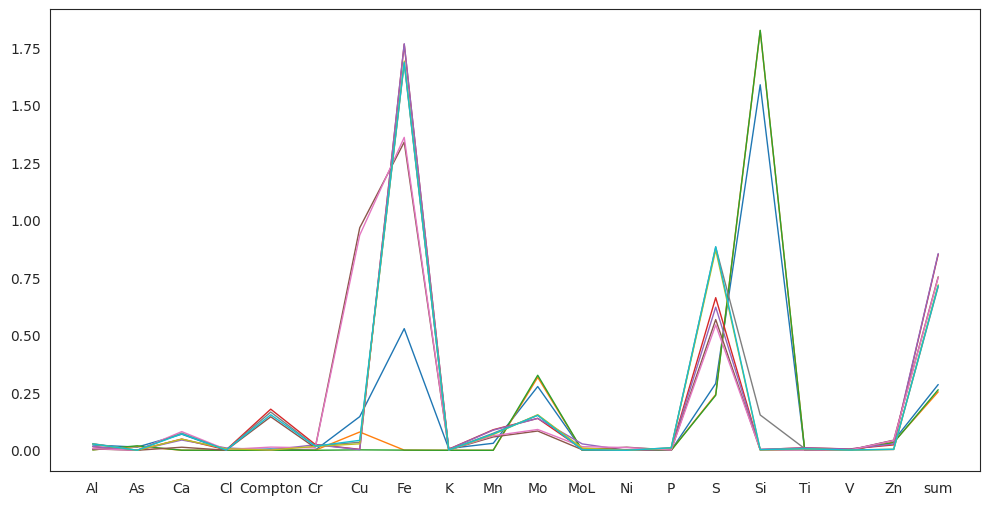

In [25]:
vis.category_avgs(categories, elements, classavg, palette=palette)